# Business Understanding

- [ ] analysis of requirements with the end user
- [ ] definition of business goals
- [ ] translation of business goals into data mining goals
- [ ] Tools and project management

## Business Objectives

**Descriptive problem**: TODO

**Predictive problem**: Predict whether a loan will end successfully.

- Classification problem
- Target: *status* column of *loan_dev.csv* file (-1 = bad, 1 = good)
- Minority (positive) class: Loan not paid (*status* = -1)
- Evaluation metric: AUC
- Reduce defaulting (minimize FPR), for example FPR < 0.25
- Don't reduce credit card approval (maximize FNR), for example FNR > 0.95


## ~~Assess Situation~~

## Data Mining Goals (TODO)

Parte disto deve estar em Business Objectives, mas não sei o que é o quê

## Project Plan (TODO)

- Methodology: CRISP-DM
- plan: TODO ?????????
- Project Management tools: ??????
- collaboration tools: Github? (idk if this is what they mean)
- Analytics Tools: ?????
- Database Tools: ?????
- other tools (e.g. data cleaning, visualization): ????


    

# Data Understanding
    
- [ ] diversity of statistical methods
- [ ] complexity of statistical methods
- [ ] interpretation of results of statistical methods
- [ ] knowledge extraction from results of statistical methods
- [ ] diversity of plots
- [ ] complexity of plots
- [ ] presentation
- [ ] interpretation of plots
- [ ] visual knowledge extraction

## Collected Data

- account.csv - relation account (4500 objects) 
- client.csv - relation client (5369 objects)
- disp.csv - relation disposition (5369 objects) 
- district.csv - relation demographic data (77 objects)
- ~~relation permanent order (0/6471 objects)~~
- trans_dev.csv - relation transaction (396685/1056320 objects)
- card_dev.csv - relation credit card (177/892 objects)
- loan_dev.csv - relation loan (328/682 objects)



In [124]:
import os
import uuid
import numpy as np 
import pandas as pd
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
# This is used in order to show the plotted figures within this notebook
%matplotlib inline 
# This is used in order to show the tensorboard within this notebook             
#%load_ext tensorboard  
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter
import missingno as msno


In [125]:
# Utils
def dict_barplot(dict):
    """From a dict {x:y} it plots a barplot"""
    lenx = len(dict.keys())
    plt.figure(figsize=(lenx/4, 4))
    plt.bar(range(lenx), list(dict.values()), align='center')
    plt.xticks(range(lenx), list(dict.keys()), rotation=90)
    plt.show()


In [126]:
accounts = pd.read_csv('data/account.csv', sep=';')
cards_dev = pd.read_csv('data/card_dev.csv', sep=';')
clients = pd.read_csv('data/client.csv', sep=';')
disp = pd.read_csv('data/disp.csv', sep=';')
districts = pd.read_csv('data/district.csv', sep=';')
loans_dev = pd.read_csv('data/loan_dev.csv', sep=';')
trans_dev = pd.read_csv('data/trans_dev.csv', sep=';')

C:\Users\PedroGoncaloCorreia\AppData\Local\Temp\ipykernel_5704\1239521831.py:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  trans_dev = pd.read_csv('data/trans_dev.csv', sep=';')


In [127]:
def info(table, name):
    print("==============")
    print(name)
    print("--------------")
    print(table.info(verbose=True, max_cols=1000, memory_usage=False, show_counts=True))

info(accounts, "accounts")
info(cards_dev, "cards_dev")
info(clients, "clients")
info(disp, "disp")
info(districts, "districts")
info(loans_dev, "loans_dev")
info(trans_dev, "transactions_dev")


accounts
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   account_id   4500 non-null   int64 
 1   district_id  4500 non-null   int64 
 2   frequency    4500 non-null   object
 3   date         4500 non-null   int64 
dtypes: int64(3), object(1)None
cards_dev
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   card_id  177 non-null    int64 
 1   disp_id  177 non-null    int64 
 2   type     177 non-null    object
 3   issued   177 non-null    int64 
dtypes: int64(3), object(1)None
clients
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  ----

Null values: Only transactions_dev has null values: operation, k_symbol, bank, account
Dates: We should confirm that for a loan in a given date we only consider accounts/clients/transactions/etc from before that date, using the respective date fields

accounts : 4500 objects
 #  | Column    |   Non-Null Count | type 
--- | ------     |  -------------- | ----- 
 0 |  account_id  | 4500 non-null |  PRIMARY KEY 
 1  | district_id|  4500 non-null |  FOREIGN KEY 
 2  | frequency  |  4500 non-null |  enum('monthly issuance', 'issuance after transaction', 'weekly issuance')
 3  | date       |  4500 non-null |  YYMMDD

- categorize/encode frequency, no order (TODO: why no order? there seems to be a order: after < weekly < monthly)
- parse date
- join on acc_id and distr_id

clients : 5369 objects
 #  | Column        |Non-Null Count|  type
--- | ------        |--------------|  -----
 0  | client_id     |5369 non-null |  PRIMARY KEY
 1  | birth_number | 5369 non-null |  YYMMDD + 5000 if woman
 2   |district_id |  5369 non-null |  FOREIGN KEY

- parse birth date
- retrieve sex and birth_date from birth_number

disp : 5369 objects
 #  | Column     | Non-Null Count | type 
--- | ------     | -------------- | ----- 
 0  | disp_id    | 5369 non-null  | PRIMARY KEY 
 1  | client_id  | 5369 non-null  | FOREIGN KEY 
 2  | account_id | 5369 non-null  | FOREIGN KEY 
 3  | type       | 5369 non-null  | enum('OWNER', 'DISPONENT')

- categorize/encode frequency, (0 = disponent, 1 = owner)

districts : 77 objects
 #  | Column                                            | Non-Null Count | type  
--- | ------                                            | -------------- | -----  
 0  | code                                              | 77 non-null    | PRIMARY KEY  
 1  | name                                              | 77 non-null    | UNIQUE KEY 
 2  | region                                            | 77 non-null    | enum('Prague', 'central Bohemia', 'south Bohemia', 'west Bohemia', 'north Bohemia', 'east Bohemia', 'south Moravia', 'north Moravia')
 3  | no. of inhabitants                                | 77 non-null    | int64  
 4  | no. of municipalities with inhabitants < 499      | 77 non-null    | int64  
 5  | no. of municipalities with inhabitants 500-1999   | 77 non-null    | int64  
 6  | no. of municipalities with inhabitants 2000-9999  | 77 non-null    | int64  
 7  | no. of municipalities with inhabitants >10000     | 77 non-null    | int64  
 8  | no. of cities                                     | 77 non-null    | int64  
 9  | ratio of urban inhabitants                       |  77 non-null    | float64
 10 | average salary                                  |   77 non-null    | int64  
 11 | unemploymant rate '95                          |    77 non-null    | object 
 12 | unemploymant rate '96                         |     77 non-null    | float64
 13 | no. of enterpreneurs per 1000 inhabitants    |      77 non-null    | int64  
 14 | no. of commited crimes '95                  |       77 non-null    | object 
 15 | no. of commited crimes '96                 |        77 non-null    | int64  

transactions_dev : 396685/1056320 objects
 #  | Column    |  Non-Null Count |  type  
--- | ------    |  -------------- |  -----  
 0  | trans_id  |  396685 non-null|  PRIMARY KEY  
 1  | account_id|  396685 non-null|  FOREIGN KEY  
 2  | date      |  396685 non-null|  YYMMDD
 3  | type      |  396685 non-null|  enum('credit', 'withdrawal', 'withdrawal in cash') 
 4  | operation |  325924 non-null|  enum('credit in cash', 'collection from another bank', 'withdrawal in cash', 'remittance to another bank', 'credit card withdrawal')
 5  | amount    |  396685 non-null|  float64 (currency unit)
 6  | balance   |  396685 non-null|  float64 (currency unit)
 7  | k_symbol  |  211441 non-null|  enum('interest credited', ' ', 'household', 'payment for statement', 'insurrance payment', 'sanction interest if negative balance', 'old-age pension')
 8  | bank      |  97242 non-null |  string (other bank ID)
 9  | account   |  102229 non-null|  account (other bank's account ID)

- type="withdrawal in cash" is redundant with operation="withdrawal in cash"
- parse date
- encode type, operation, bank
- handle nulls on operation, k_symbol, bank and account

cards_dev : 177/892 objects
 #  | Column  | Non-Null Count | type 
--- | ------  | -------------- | ----- 
 0  | card_id | 177 non-null   | PRIMARY KEY 
 1  | disp_id | 177 non-null   | FOREIGN KEY 
 2  | type    | 177 non-null   | enum('classic', 'junior', 'gold')
 3  | issued  | 177 non-null   | YYMMDD 

- encode type, ordered
- parse issued

loans_dev : 328/682 objects
 #  | Column     | Non-Null Count | type
--- | ------     | -------------- | -----
 0  | loan_id    | 328 non-null   | PRIMARY KEY
 1  | account_id | 328 non-null   | FOREIGN KEY
 2  | date       | 328 non-null   | YYMMDD
 3  | amount     | 328 non-null   | int (currency unit) 
 4  | duration   | 328 non-null   | int (number of months)
 5  | payments   | 328 non-null   | derived(amount/duration)
 6  | **status** |     328 non-null  |  TARGET (1 = paid, -1 = not paid)

- parse date
- binarize status (1 = not paid, 0 = paid)
- encode duration by year (is by month atm, but always multiples of 12)
- normalize amount OR payments
- remove payments OR amount


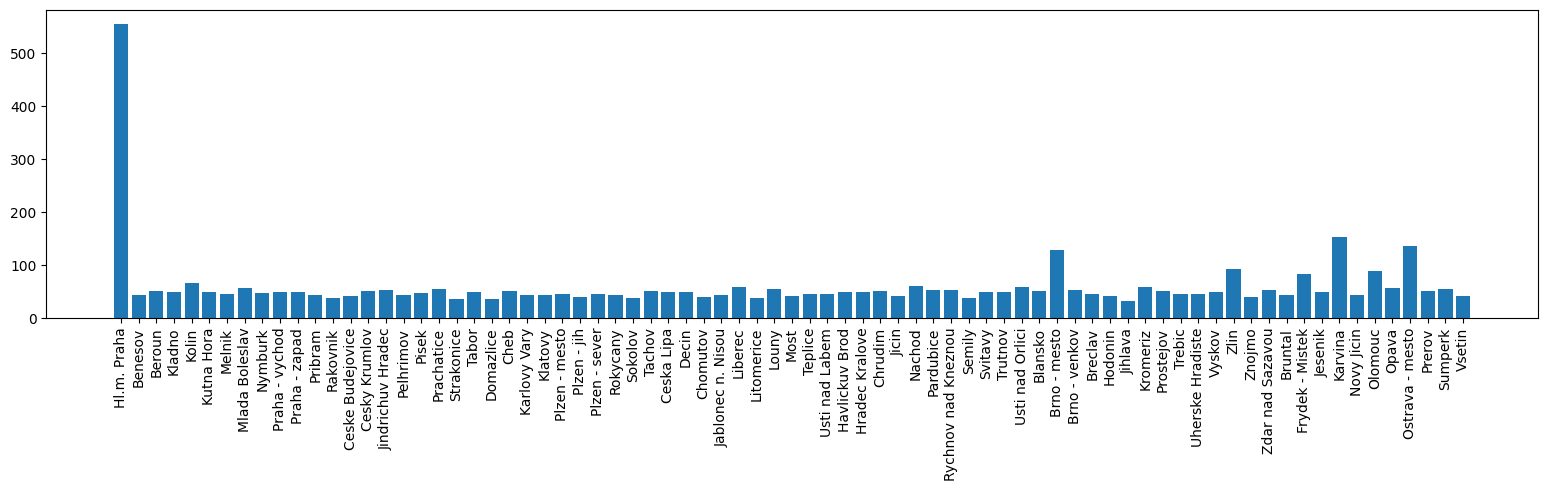

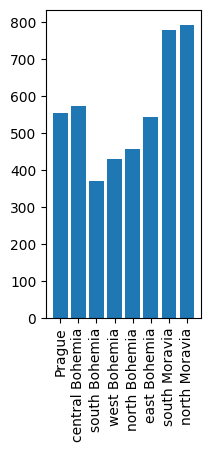

In [128]:
# Account -*----------1-> District

# How many accounts have each district

accounts_count_per_district_array = accounts.value_counts('district_id').sort_index().array
accounts_count_per_district = { name: accounts_count_per_district_array[idx - 1] for idx, name in districts[['code ', 'name ']].values}


accounts_count_per_region = {} 
for idx, region in districts[['code ', 'region']].values:
    accounts_count_per_region[region] = accounts_count_per_region.get(region, 0) + accounts_count_per_district_array[idx - 1]

dict_barplot(accounts_count_per_district)
dict_barplot(accounts_count_per_region)

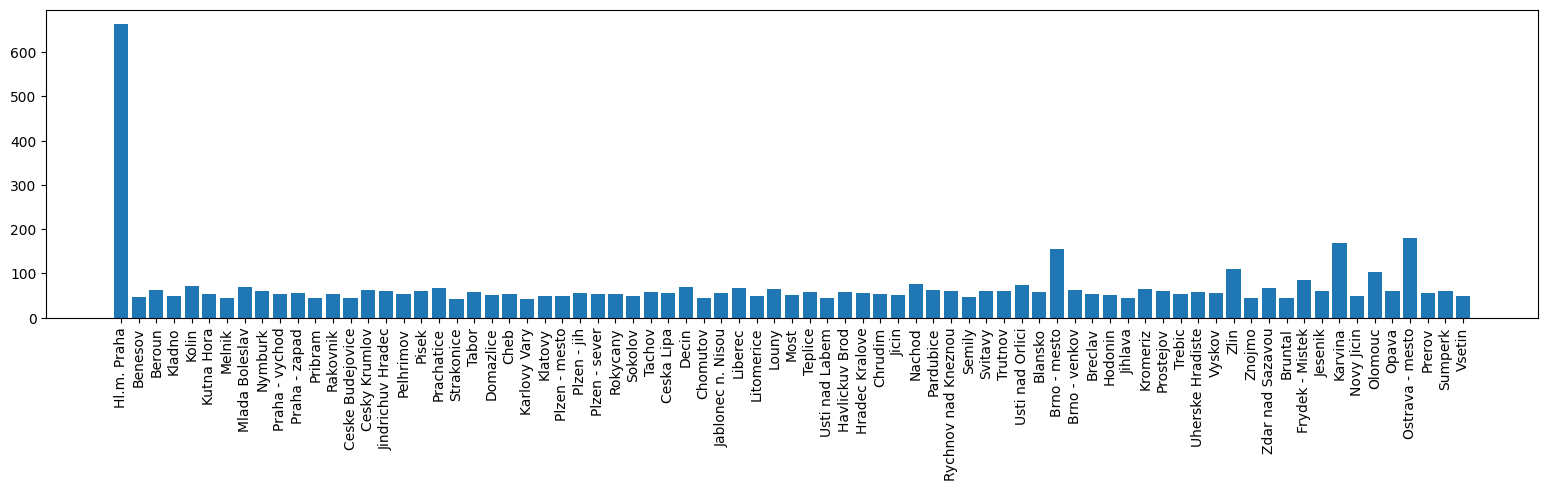

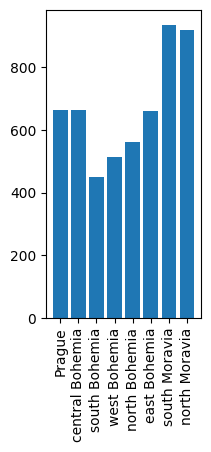

In [129]:
# Client -*----------1-> District

# How many clients have each district

client_count_per_district_array = clients.value_counts('district_id').sort_index().array
client_count_per_district = { name: client_count_per_district_array[idx - 1] for idx, name in districts[['code ', 'name ']].values}


client_count_per_region = {} 
for idx, region in districts[['code ', 'region']].values:
    client_count_per_region[region] = client_count_per_region.get(region, 0) + client_count_per_district_array[idx - 1]

dict_barplot(client_count_per_district)
dict_barplot(client_count_per_region)

In [131]:
# Account <-1----------1..2- Disposition -1----------1-> Client


clients_dict = {}
for idx, client, account, type in disp[['disp_id', 'client_id', 'account_id', 'type']].values:
    if client in clients_dict:
        print("DUPLICATE CLIENT", clients_dict[client])
        # THERE ARE NO DUPLICATE CLIENTS: client_id is just as unique as disp_id
        
    clients_dict[client] = clients_dict.get(client, 0) + 1

print("No clients missing from disposition:", set(clients['client_id'].values) == set(disp['client_id'].values))
print("No accounts missing from disposition:", set(accounts['account_id'].values) == set(disp['account_id'].values))

# EVERY ACCOUNT HAS 1 OWNER AND 0..1 DISPONENTS
for account in set(accounts['account_id'].values):
    disp_row = disp[disp['account_id'] == account]
    types = disp_row['type'].value_counts()
    if types.get('OWNER', 0) != 1:
        print("Account", account, "has", types.get('OWNER', 0), "owners")
    if types.get('DISPONENT', 0) != 0 and types.get('DISPONENT', 0) != 1:
        print("Account", account, "has", types.get('DISPONENT', 0), "disponents")

No clients missing from disposition: True
No accounts missing from disposition: True


In [152]:
# acc_district != owner_district != disponent_district
for account, acc_district in accounts[['account_id', 'district_id']].values:
    disp_row = disp[disp['account_id'] == account]
    owner_id = disp_row[disp_row['type'] == 'OWNER']['client_id'].values[0]
    owner = clients[clients['client_id'] == owner_id]
    owner_district = owner['district_id'].values[0]

    disponent_id = disp_row[disp_row['type'] == 'DISPONENT']
    if disponent_id.shape[0] == 1:
        disponent_id = disponent_id['client_id'].values[0]
        disponent = clients[clients['client_id'] == disponent_id]
        disponent_district = disponent['district_id'].values[0]
        print(acc_district, owner_district, disponent_district)
    else:
        print(acc_district, owner_district)


55 74 74
74 1 1
55 22 22
16 16
24 24
77 46
1 64
47 76 76
74 74
76 76
48 48 48
70 70
19 19
62 28
6 75
21 5
70 70
44 44
37 58 58
10 25
41 41
36 36 36
1 1
26 9 9
55 55
1 1
7 8
68 29
54 54
41 49
38 38
1 1
41 41
38 38
1 1
9 9
60 60
44 34
26 27 27
37 37
74 74 74
14 40
3 3 3
44 41
44 44
53 53
1 15
50 50
33 33 33
15 15
4 4
55 55 55
15 54
32 32
1 1
54 54
40 40 40
54 54 54
66 19
27 27
49 49
47 47
45 1
52 14
74 44
60 60 60
73 21
41 50
74 74 74
25 8
41 41
68 70
23 23
66 66
75 75
1 1
54 3
77 77
1 1
68 68 68
12 4
46 74
13 13
27 27
30 30
48 48
70 40
59 69
32 32
63 63
64 74
61 61 61
72 72
12 14
1 52
40 40
36 13 13
44 30
1 48
17 1
16 15
68 68
64 70
1 1 1
54 15
1 1
7 7
67 45
1 32
32 32
54 54
70 70
14 60
63 63
61 61
64 64 64
48 38
1 31 31
73 28
6 6
70 57
1 77
10 20 20
74 74
24 12
1 1
50 50
6 6
74 74 74
45 45
57 57
6 6
10 10 10
38 75
16 16
75 75
16 16
64 64
51 51
72 43
27 1
46 46
68 46
31 31
1 63
30 38
51 51 51
74 74
13 13
21 21
66 66
51 51
16 16
21 21
68 74 74
30 30 30
1 19
24 59
10 71
71 8
50 50
70 70
2

In [157]:
# Card -1----------1-> Disponent
disponents_dict = {}
for idx, disponent in cards_dev[['card_id', 'disp_id']].values:
    if disponent in disponents_dict:
        print("DUPLICATE DISPONENT", disponents_dict[disponent])
        # THERE ARE NO DUPLICATE DISPONENTS: disp_id is just as unique as card_id
    disponents_dict[disponent] = disponents_dict.get(disponent, 0) + 1

print("No disps missing from cards:", set(disp['disp_id'].values) == set(cards_dev['disp_id'].values))

No disps missing from cards: False


In [182]:
# Transaction -0..*----------1-> Account
print("No accounts missing from transactions:", set(accounts['account_id'].values) == set(trans_dev['account_id'].values))

accounts_dict = {account: 0 for account in accounts['account_id'].values}
for idx, account in trans_dev[['trans_id', 'account_id']].values:
    accounts_dict[account] = accounts_dict.get(account, 0) + 1

print("Accounts in dev have between", min(accounts_dict.values()), "and", max(accounts_dict.values()), "transactions")


No accounts missing from transactions: False
Accounts in dev have between 0 and 441 transactions


In [185]:
# Loan -0..1----------1-> Account
accounts_dict = {}
for idx, account in loans_dev[['loan_id', 'account_id']].values:
    if account in accounts_dict:
        print("DUPLICATE ACCOUNT", accounts_dict[account])
        # THERE ARE NO DUPLICATE ACCOUNTS: account_id is just as unique as loan_id
    accounts_dict[account] = accounts_dict.get(account, 0) + 1

print("No accounts missing from loans:", set(accounts['account_id'].values) == set(loans_dev['account_id'].values))

No accounts missing from loans: False


<AxesSubplot: >

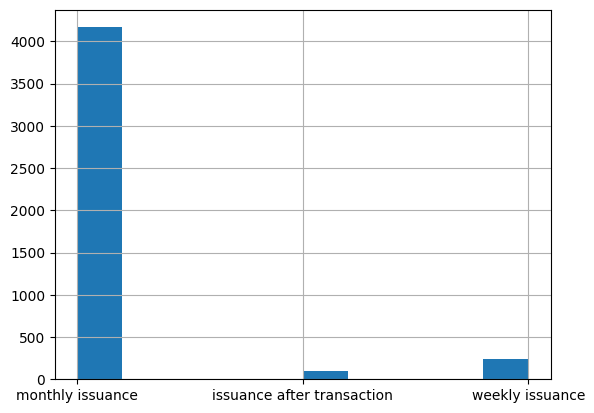

In [19]:
accounts['frequency'].hist()

<AxesSubplot: >

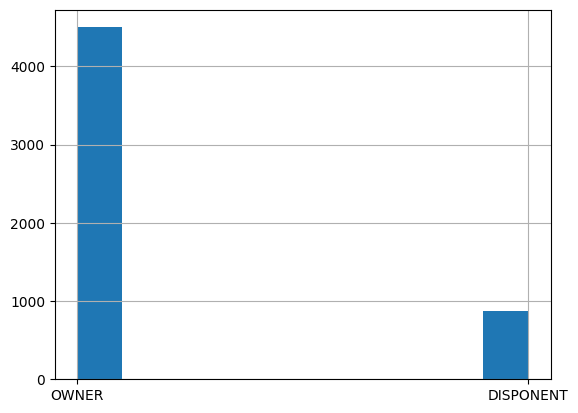

In [20]:
disp['type'].hist()

C:\Users\PedroGoncaloCorreia\AppData\Local\Temp\ipykernel_5704\102409225.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = g.set_xticklabels(g.get_xticklabels(), rotation=90)


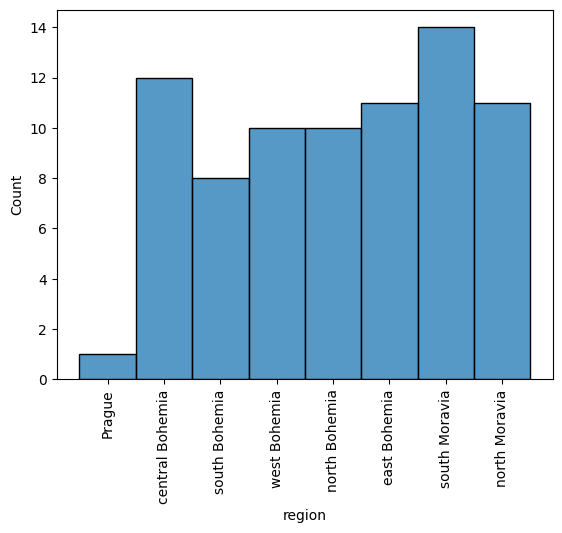

In [25]:
# x labels rotated 90º
g = sns.histplot(districts, x='region')
_ = g.set_xticklabels(g.get_xticklabels(), rotation=90)


<AxesSubplot: >

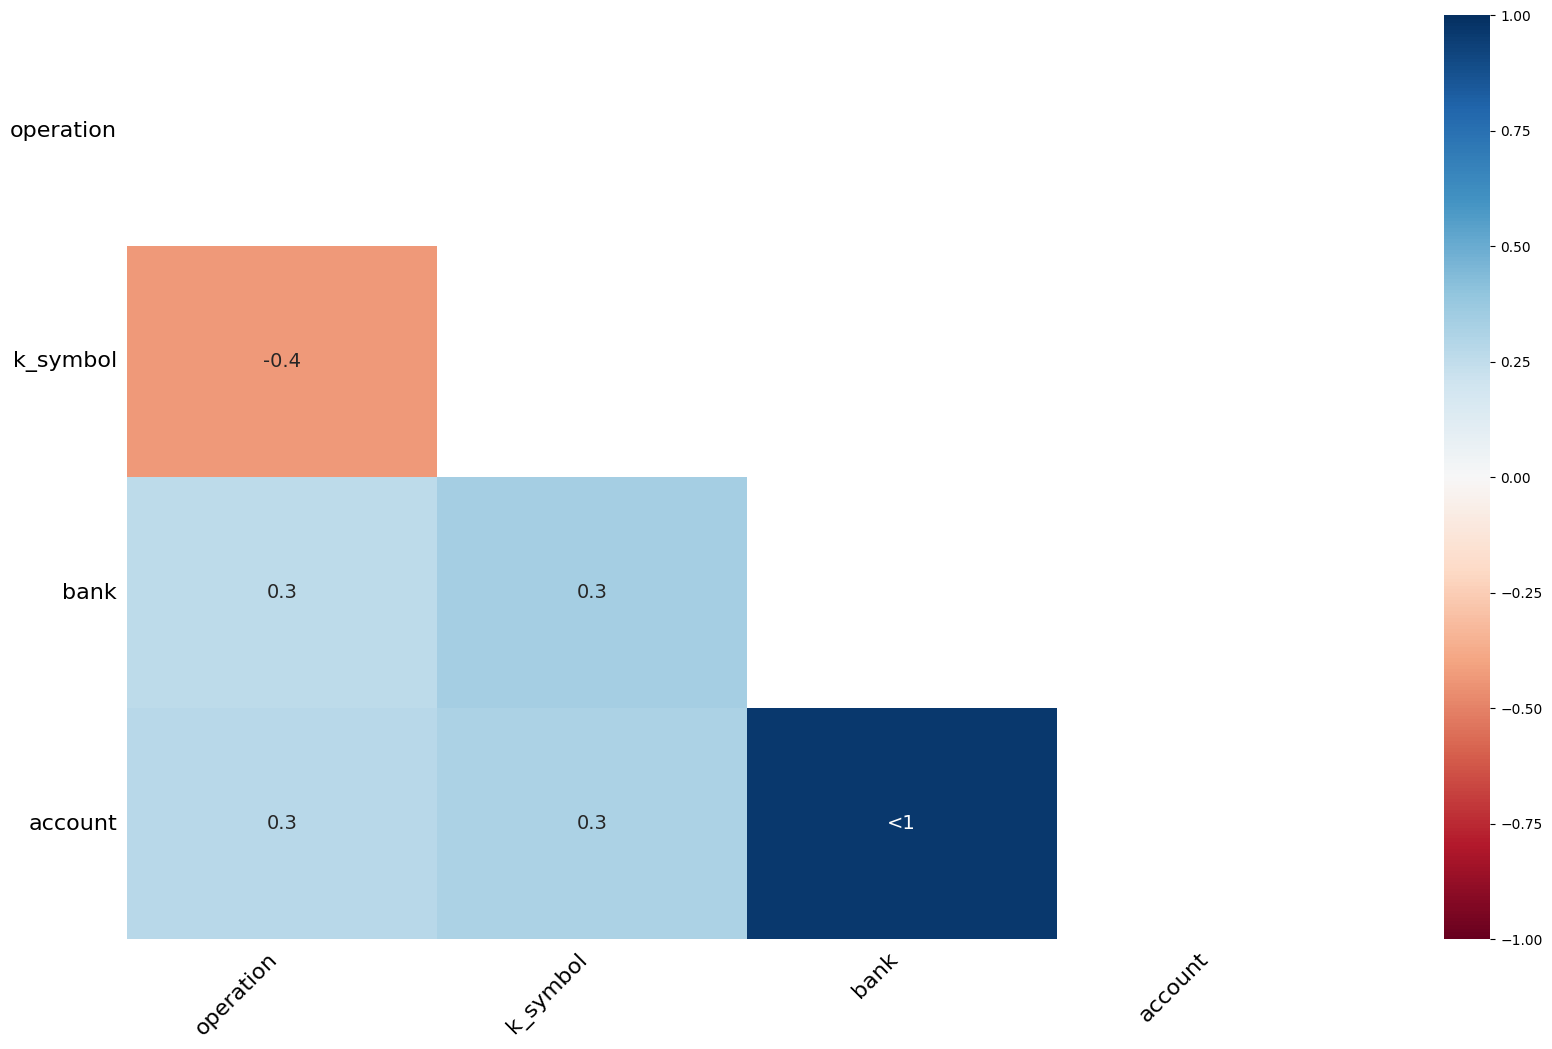

In [10]:
msno.heatmap(trans_dev)

<AxesSubplot: >

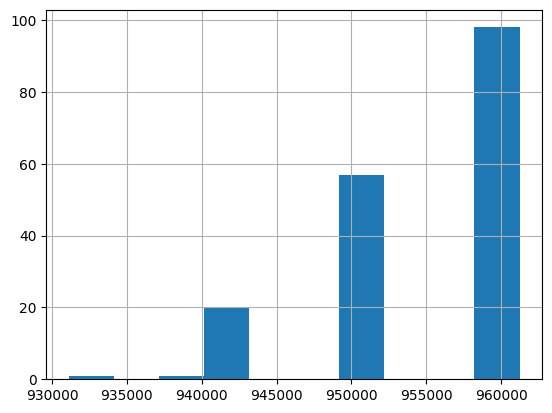

In [11]:
cards_dev['issued'].hist()